# Data manipulation
***

0. [Loading the data](#load)
1. [Introduction](#intro)
1. [Turning defects into a dichotomous variable](#dich)
1. [Oversampling](#os)
1. [Splitting the data](#split)

 ### 0. Loading the data<a id='load'>

To load our data, we just run the <a href='loading_data.ipynb'>script we created for the purpose</a>

In [1]:
%%capture 
%run 1_loading_data.ipynb

### 1. Introduction

A very important step in data analysis is data manipulation. Manipulation is the process of changing the data, in order to make it more readable and usable. In our <a href='eda.ipynb'>explorative data analysis</a>, we've seen that our datasets are strongly imbalanced on the 0. In this section, we will apply two manipulations: first of all, we will turn `defects` into a **dichotomous variable**, admitting just two values: <ul><li><b>0</b> for classes without defects</li><li><b>1</b> for classes that present one or more defects</li></ul> Then, we will apply a technique called **oversampling**, in order to improve the prediction of 1s.

### 2. Turning defects into a dichotomous variable<a id='dich'>

Let's start by defining a function that, taken a DataFrame as input, returns the same DataFrame in which the values of `defects > 1` has been turned into `1`

In [2]:
def transform_defects(dataFrame):
    to_change = dataFrame[dataFrame['defects']>=2].index
    for index in to_change:
        dataFrame['defects'][index] = 1.0
    return dataFrame

Now we can transform our datasets:

In [3]:
for key in names:
    datasets[key] = transform_defects(datasets[key])

Let's explore the transformed datasets:

In [4]:
def plot_zero_one(datasets, names, fileName):
    bars = len(names)
    plt.figure(figsize=(15,7))
    x_pos = np.arange(bars)
    heigths = [[],[]]

    for key in names:
        for i in (0,1):
            heigths[i].append(datasets[key]['defects'].value_counts()[i])

    plt.bar(x_pos - 0.2, heigths[0], 0.4, label = '0', color='#55CC55', edgecolor='black')
    plt.bar(x_pos + 0.2, heigths[1], 0.4, label = '1', color='#AA3333', edgecolor='black')

    plt.xticks(x_pos, names)
    plt.xlabel("Dataset")
    plt.ylabel("Classes")
    plt.title("Defected classes")
    plt.legend()
    savefig(fileName)
    plt.show()

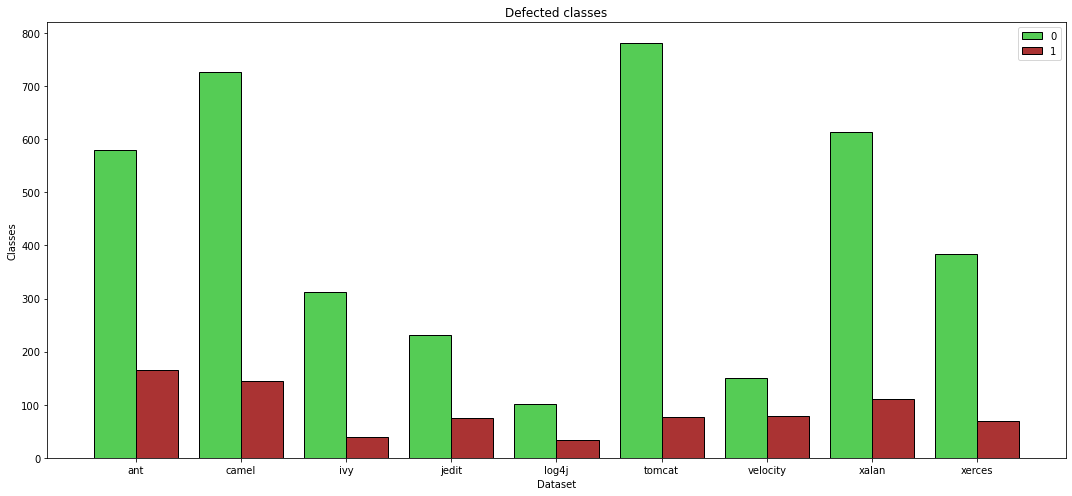

In [5]:
plot_zero_one(datasets, names, 'defect_distribution_in_transformed_data')

As we can see, now `defects` assumes only 0 (standing for `False`)  and 1 (standing for `True`). This makes the prediction of presence of defective classes more reliable than before, but our distribution is still imbalanced.

### 3. Oversampling

Oversampling is a solution for strongly imbalanced datasets. Classic oversampling simply consists in duplicating values from the minority classes. The main problem with this techinque is that it makes the model *overfitted*, because the minority classes will just have the same observation replicated a large number of times, and obvoiusly this observation will have an enormous weight in the prediction process. 

So, we may use a different technique known as **SMOTE** (Synthetic Minority Oversampling Technique). Instead of just duplicating the values, SMOTE algorithm works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.

This method produces the so called *synthethic examples*

**In order to use the SMOTE algorithm, we will need a library contained in a package called `imbalanced-learn`** (it can be installed in Anaconda by running `conda install -c conda-forge imbalanced-learn`, but it is also included in many other repositories such as `pip` or `apt`)

First of all, we need to import the library

In [6]:
from imblearn.over_sampling import SMOTE

The SMOTE class acts just like a data transform object from scikit-learn, in the sense that it must be first defined and configured, then fit on a dataset and in the end applied to create a new transformed version of the dataset.

In [7]:
def oversample(dataFrame):
    smote = SMOTE(sampling_strategy=0.85) #this parameter means that we will have a ratio between the n. of 1 and the n. of 0 equal to 0.85
    x = dataFrame.drop('defects', axis=1)
    y = dataFrame.defects
    x, y = smote.fit_resample(x,y)
    return pd.concat([x,y], axis=1)

We will store oure oversampled datasets into a new dictionary, called `oversampled`, structured the same way as `datasets`:

In [8]:
oversampled=dict()
for key in names:
    oversampled[key] = oversample(datasets[key])

Let's see now, for istance, the distribution of `ant`:

In [9]:
oversampled['ant']['defects'].value_counts()

0.0    579
1.0    492
Name: defects, dtype: int64

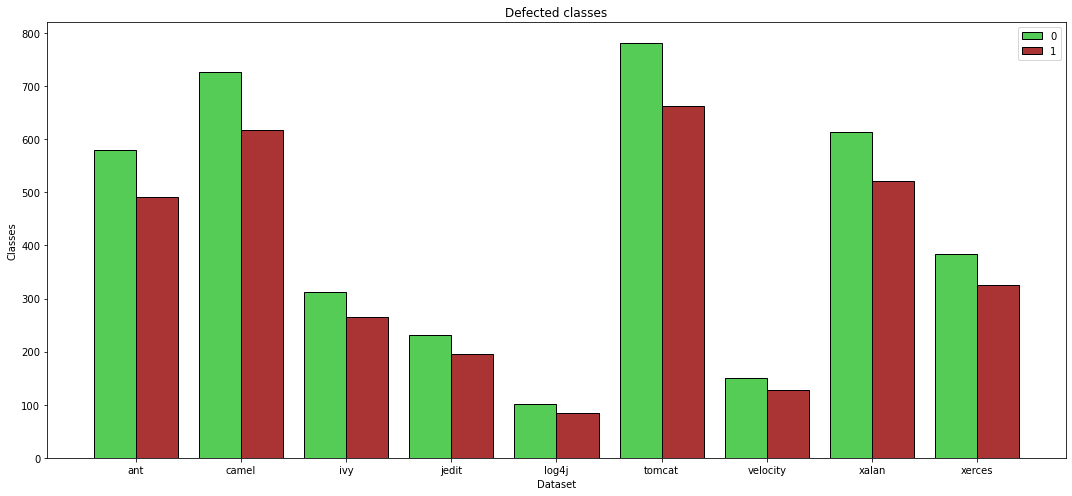

In [10]:
plot_zero_one(oversampled, names, 'defects_distribution_in_oversampled_data')

### 4. Splitting the data<a href='split'>

Our need, now, is to **split** each dataset into 2 parts: one for *training* and one for *testing*.

The *training* set will be used by our models to learn the way to make the prediction, while the *testing* set will be used to evaluate the models' performances.
An appropriate ratio could be `80%-20%`.

Let's define a function that will help us to split datasets faster:

In [11]:
from sklearn.model_selection import train_test_split
def split(dataFrame):
    y = dataFrame.defects
    x = dataFrame.drop('defects', axis=1)
    x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2)
    return x_train, x_test, y_train, y_test

First of all, our function will remove the variable to predict (in our case, `defects`) from the dataset, and assign it to a new set `Y`, while `X` will now be the **original dataset without `defects`**. Then, it will split `X` and `Y` into 2 parts, one for training and one for testing. As a result, it will create 4 new variables per each dataset:
<ul>
    <li>X train</li>
    <li>X test</li>
    <li>Y train</li>
    <li>Y test</li>
</ul>

We decide to store our splitted sets into a new dictionary, structured as

`dataset: list(xtrain, xtest, ytrain, ytest)`

As before, the main reason we use this method is practical: later, we will need to repeat the same operations for every dataset, and, this way, we will be able to use loops.

`splitted[dataset][0]`: X Train

`splitted[dataset][1]`: X Test

`splitted[dataset][2]`: Y Train

`splitted[dataset][3]`: Y Test

In [12]:
splitted = dict()
for key in names:
    xtrain, xtest, ytrain, ytest = split(oversampled[key])
    splitted[key] = [xtrain, xtest, ytrain, ytest]

First of all, let's see the lenght of our new sets:

In [13]:
lengths_matrix = []
for key in names:
    length = []
    for i in range(2):
        length.append(len(splitted[key][i]))
    lengths_matrix.append(length)

lengths_matrix = pd.DataFrame(lengths_matrix).transpose()
lengths_matrix.index = ['Training set','Testing set']
lengths_matrix.columns = list(oversampled.keys())

lengths_matrix

,ant,camel,ivy,jedit,log4j,tomcat,velocity,xalan,xerces
Training set,856,1075,461,341,148,1155,223,907,568
Testing set,215,269,116,86,38,289,56,227,142


As we can see, our function assigned the 80% of the obs. to the training sets, and 20% to the testing sets.

Let's explore `ant` to see how did it work:

In [14]:
splitted['ant'][0].head() # head of ant X train 

,wmc,dit,noc,cbo,rfc,lcom,ca,ce,npm,lcom3,loc,dam,moa,mfa,cam,ic,cbm,amc,max_cc,avg_cc
426,2.000000,1.000000,0.0,2.000000,3.000000,0.000000,2.000000,0.000000,1.000000,0.000000,12.000000,1.000000,0.000000,0.000000,0.750000,0.000000,0.000000,4.500000,1.000000,0.500000
925,7.837126,2.472854,0.0,6.527146,61.434331,15.092815,0.527146,6.527146,5.309980,0.921191,379.472854,0.947461,0.472854,0.832178,0.389872,0.472854,0.472854,54.694871,6.798602,2.073756
326,12.000000,1.000000,0.0,19.000000,33.000000,66.000000,13.000000,7.000000,10.000000,1.045455,261.000000,0.000000,0.000000,0.000000,0.259259,0.000000,0.000000,20.583333,8.000000,1.916700
825,6.644276,4.644276,0.0,8.355724,31.677862,11.254968,0.000000,8.355724,3.322138,0.396351,170.725162,1.000000,1.000000,0.927396,0.357143,1.644276,3.577106,25.247318,2.677862,1.298664
503,9.000000,3.000000,0.0,8.000000,38.000000,14.000000,1.000000,8.000000,7.000000,0.875000,345.000000,1.000000,0.000000,0.766667,0.375000,3.000000,5.000000,36.555556,3.000000,1.222200


We can notice how `defects` has been dropped from the rest of the set.

In [15]:
splitted['ant'][2].value_counts() #value counts of ant Y train

0.0    470
1.0    386
Name: defects, dtype: int64

Now we are ready to perform the analysis